In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [2]:
metadata_df = pd.read_csv("../data/metadata_df_v5.csv")
metadata_df.head()

chip_id      date               sample_id     type  source  \
0  00786_05_c_Q4_20171016  20171016  00786_05_c_Q4_20171016  control  S2 WCD   
1  00786_05_c_Q3_20170713  20170713  00786_05_c_Q3_20170713  control  S2 WCD   
2  00786_05_c_Q2_20170409  20170409  00786_05_c_Q2_20170409  control  S2 WCD   
3  00786_05_c_Q1_20170320  20170320  00786_05_c_Q1_20170320  control  S2 WCD   
4  00786_05_c_Q4_20191011  20191011  00786_05_c_Q4_20191011  control  S2 WCD   

   x_center   y_center   epsg  
0  607460.0  4628130.0  32630  
1  607460.0  4628130.0  32630  
2  607460.0  4628130.0  32630  
3  607460.0  4628130.0  32630  
4  607460.0  4628130.0  32630

In [3]:
metadata_df.value_counts("type")

type
control    12322
event       4676
Name: count, dtype: int64

In [4]:
gdf_list = []

for epsg_code, group in metadata_df.groupby("epsg"):
    # Build geodataframe for this EPSG
    gdf = gpd.GeoDataFrame(
        group,
        geometry=[Point(xy) for xy in zip(group.x_center, group.y_center)],
        crs=f"EPSG:{epsg_code}"
    )
    # Reproject to common CRS (WGS84)
    gdf = gdf.to_crs(epsg=4326)
    gdf_list.append(gdf)

# gdf_all = pd.concat(gdf_list).pipe(gpd.GeoDataFrame)
gdf_all = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True), crs="EPSG:4326")
gdf_all.head()

chip_id      date               sample_id   type source  \
0  00686_13_e_Q2_20230421  20230421  00686_13_e_Q2_20230421  event   MTBS   
1  00686_13_e_Q1_20230215  20230215  00686_13_e_Q1_20230215  event   MTBS   
2  00686_11_e_Q2_20230421  20230421  00686_11_e_Q2_20230421  event   MTBS   
3  00686_11_e_Q1_20230215  20230215  00686_11_e_Q1_20230215  event   MTBS   
4  00686_10_e_Q2_20230421  20230421  00686_10_e_Q2_20230421  event   MTBS   

   x_center   y_center   epsg                     geometry  
0  619670.0  6957460.0  32604  POINT (-156.65881 62.72802)  
1  619670.0  6957460.0  32604  POINT (-156.65881 62.72802)  
2  626390.0  6959700.0  32604   POINT (-156.5258 62.74585)  
3  626390.0  6959700.0  32604   POINT (-156.5258 62.74585)  
4  624150.0  6959700.0  32604   POINT (-156.5696 62.74662)

In [5]:
gdf_control = gdf_all[gdf_all["type"]=="control"]
gdf_event = gdf_all[gdf_all["type"]=="event"]
print(len(gdf_control))
print(len(gdf_event))

12322
4676


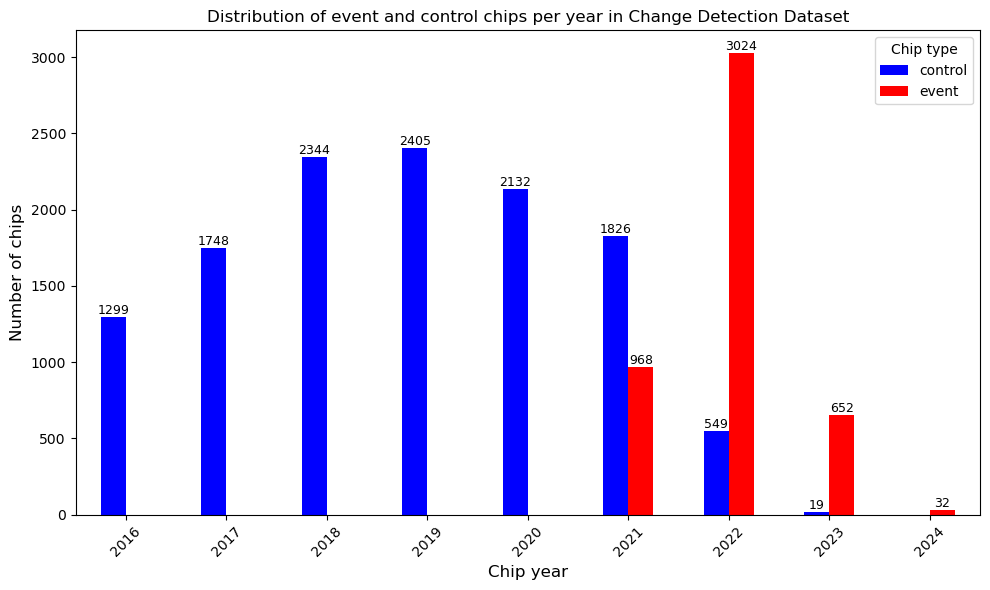

In [6]:
df = gdf_all.copy()
df["year"] = df["date"].astype(str).str[:4].astype(int)
counts = df.groupby(["year", "type"]).size().unstack(fill_value=0)
ax = counts.plot(
    kind="bar",
    figsize=(10, 6),
    color={"event": "red", "control": "blue"}
)

ax.set_title("Distribution of event and control chips per year in Change Detection Dataset")
ax.set_xlabel("Chip year", fontsize=12)
ax.set_ylabel("Number of chips", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Chip type")

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(
            f"{int(height)}",              
            (p.get_x() + p.get_width() / 2, height),
            ha="center", va="bottom", fontsize=9, color="black", rotation=0
        )

plt.tight_layout()
plt.show()

In [7]:
gdf_event.explore(
    column="type",
    categorical=True,
    legend=True,
    tooltip=["chip_id", "date", "type"],
    popup=True,
    # marker_kwds=dict(radius=2, fill=True)
)

Image Statistics

In [8]:
# TODO: Visualize histogram of per band images for event and control chips
# TODO: Compute the statistics (min, max, mean, std) for each band and visualize them
# TODO: Visualize random samples of aligned event and control chips with information on the pre and post event dates
# TODO: 

In [9]:
import os, glob
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
from scipy.stats import iqr

# ---------------------------
# Load .tif chips per group
# ---------------------------
def load_tif(path):
    with rasterio.open(path) as src:
        arr = src.read()  # (bands, H, W)
    return arr.astype(np.float32)

def collect_arrays(chip_dir, pattern):
    files = glob.glob(os.path.join(chip_dir, pattern))
    arrays = []
    for f in files:
        try:
            arrays.append(load_tif(f))
        except Exception as e:
            print("Skipping:", f, e)
    return arrays

In [10]:

# Example: adjust chip_dir to your dataset folder
chip_dir = "../data/fire_data_v5/"

event_arrays   = collect_arrays(chip_dir, "*_e_Q*.tif")
control_arrays = collect_arrays(chip_dir, "*_c_Q*.tif")

print(f"Loaded {len(event_arrays)} event chips, {len(control_arrays)} control chips")

# ---------------------------
# Compute per-band statistics
# ---------------------------
def compute_stats(arrays):
    if not arrays:
        return None

    # Stack along first axis: (Nchips, Bands, H, W)
    arrays = np.stack(arrays, axis=0)

    B = arrays.shape[1]
    stats = []
    for b in range(B):
        band_vals = arrays[:, b].ravel()
        band_vals = band_vals[~np.isnan(band_vals)]  # drop NaN if any
        stats.append({
            "band": b+1,
            "mean": np.mean(band_vals),
            "min": np.min(band_vals),
            "max": np.max(band_vals),
            "std": np.std(band_vals),
            "iqr": iqr(band_vals)
        })
    return pd.DataFrame(stats)

event_stats   = compute_stats(event_arrays)
control_stats = compute_stats(control_arrays)

print("\nEvent stats:\n", event_stats)
print("\nControl stats:\n", control_stats)

Loaded 4676 event chips, 12322 control chips

Event stats:
    band         mean  min      max          std     iqr
0     1   966.628174  0.0  18136.0  1357.740845   478.0
1     2  1183.817993  0.0  17497.0  1314.434814   570.0
2     3  1395.232056  0.0  16536.0  1341.739136   836.0
3     4  2392.235352  0.0  16120.0  1219.444824   934.0
4     5  2642.391846  0.0  15267.0  1015.296692  1441.0
5     6  2070.379883  0.0  15104.0   923.946167  1319.0

Control stats:
    band         mean  min      max          std     iqr
0     1   895.359863  0.0  17808.0  1496.619385   426.0
1     2  1137.162720  0.0  17536.0  1466.272705   499.0
2     3  1335.323364  0.0  16976.0  1490.328003   738.0
3     4  2407.419678  0.0  16544.0  1280.549927   738.0
4     5  2635.923828  0.0  15279.0   904.837219  1197.0
5     6  1926.216797  0.0  15203.0   790.407104  1067.0


In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_histograms(arrays, label, bins=100, band_names=None, color="C0", alpha=0.6):
    """
    Professional histogram plotting for per-band images.

    arrays: list of np.ndarray, each (B, H, W)
    label: group label (e.g., "Event", "Control")
    bins: number of histogram bins
    band_names: optional list of band labels
    color: matplotlib color
    alpha: transparency for bars
    """
    if not arrays:
        return
    arrays = np.stack(arrays, axis=0)  # (N, B, H, W)
    B = arrays.shape[1]

    fig, axes = plt.subplots(1, B, figsize=(5*B, 4), squeeze=False)

    for b in range(B):
        ax = axes[0, b]
        vals = arrays[:, b].ravel()
        vals = vals[~np.isnan(vals)]  # remove NaN if any

        # histogram with density normalization
        ax.hist(vals, bins=bins, alpha=alpha, color=color, density=True, edgecolor="black", linewidth=0.4)

        # mean & std lines
        mean_val = np.mean(vals)
        std_val = np.std(vals)
        ax.axvline(mean_val, color="k", linestyle="--", linewidth=1, label=f"Mean = {mean_val:.2f}")
        ax.axvline(mean_val+std_val, color="r", linestyle=":", linewidth=1, label=f"±1 Std = {std_val:.2f}")
        ax.axvline(mean_val-std_val, color="r", linestyle=":", linewidth=1)

        title = f"{label} - Band {b+1}" if band_names is None else f"{label} - {band_names[b]}"
        ax.set_title(title, fontsize=12, fontweight="bold")
        ax.set_xlabel("Pixel Value", fontsize=11)
        ax.set_ylabel("Density", fontsize=11)

        ax.grid(True, linestyle="--", alpha=0.5)
        ax.legend(fontsize=9, loc="upper right", frameon=False)

    plt.suptitle(f"Per-band Histograms ({label})", fontsize=14, fontweight="bold", y=1.05)
    plt.tight_layout()
    plt.show()


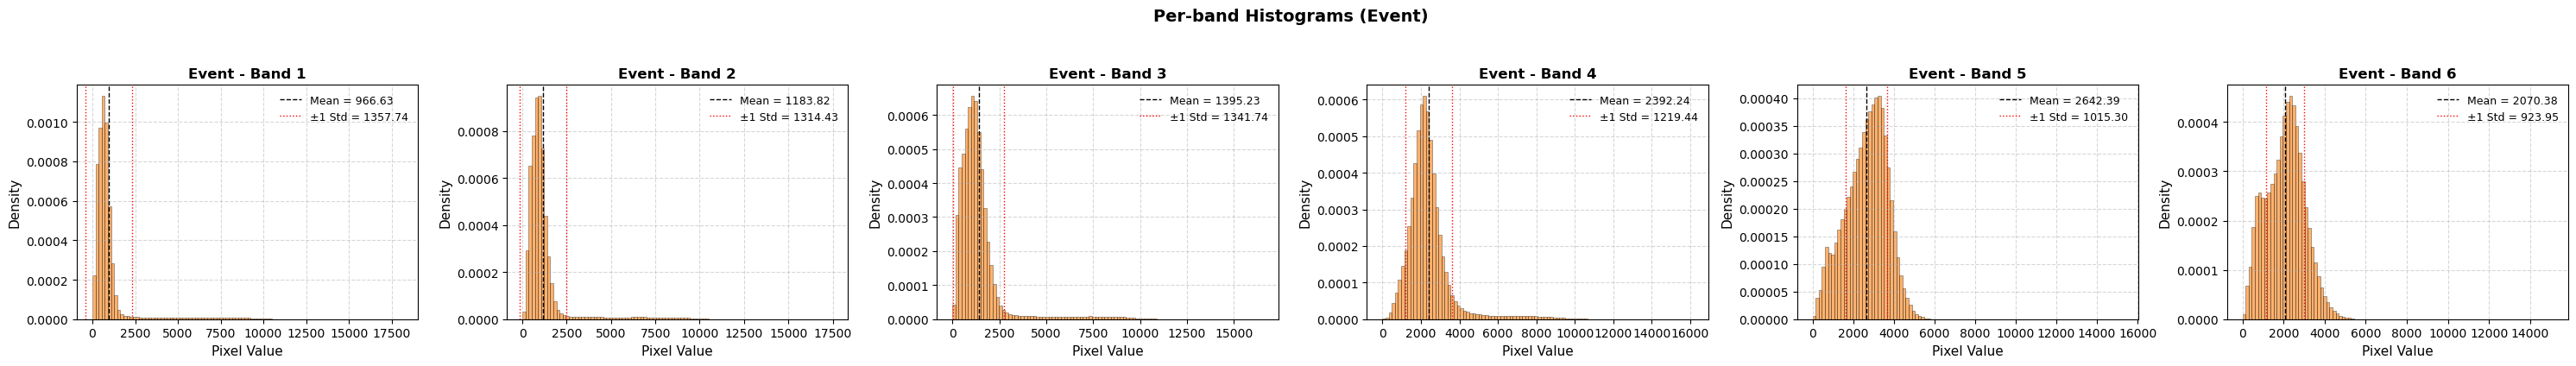

In [14]:
plot_histograms(event_arrays, "Event", color="C1")

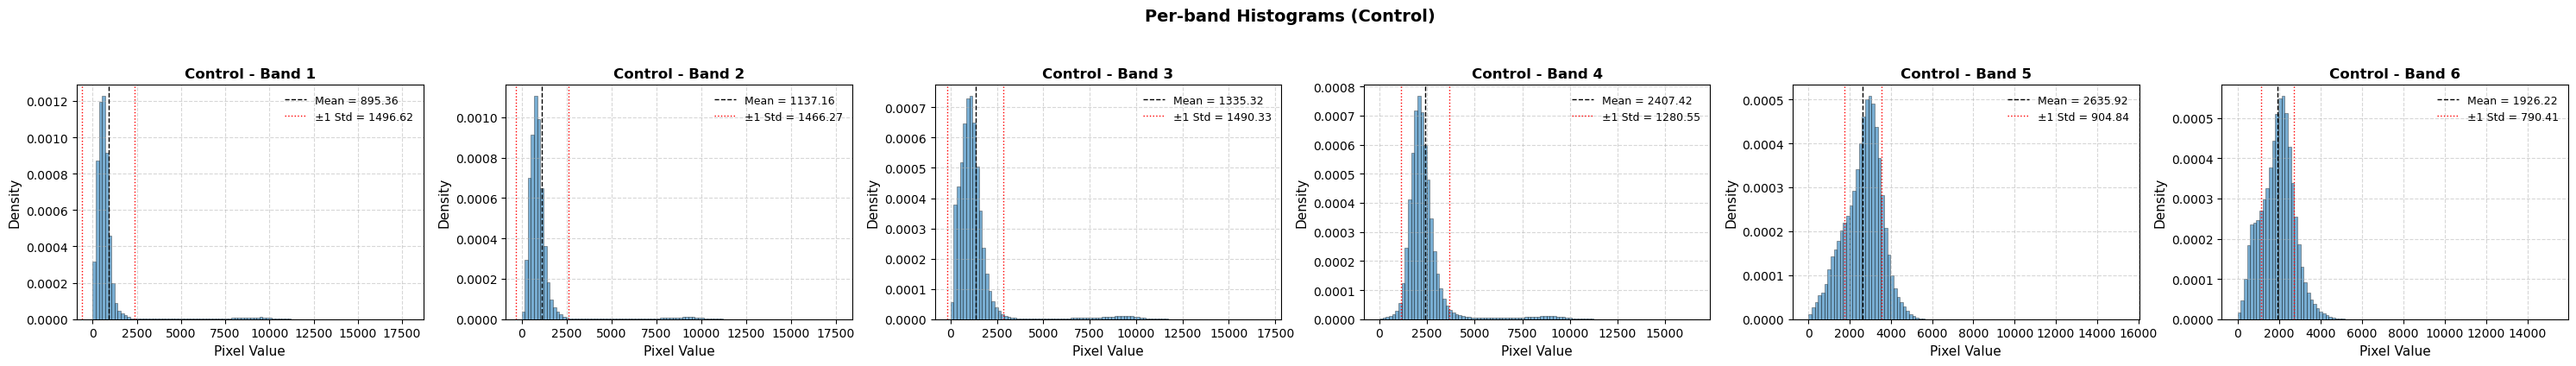

In [15]:
plot_histograms(control_arrays, "Control", color="C0")  # blue

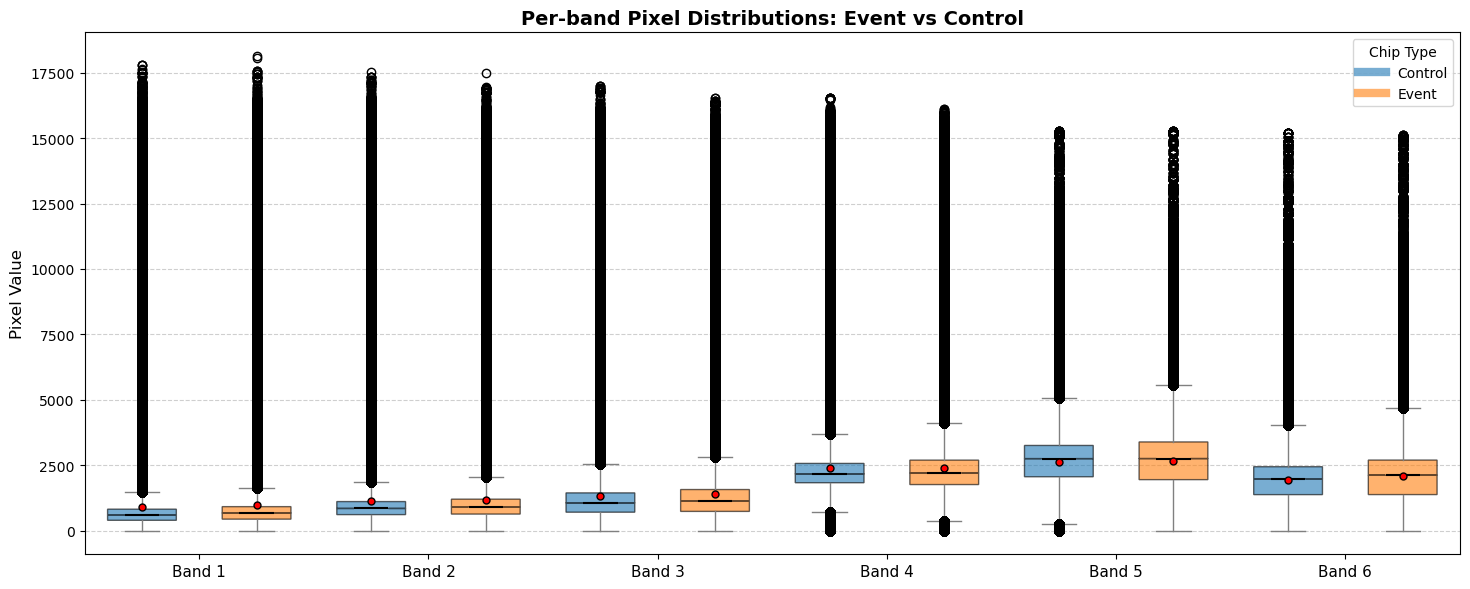

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_boxplots(event_arrays, control_arrays, band_names=None):
    """
    Professional boxplots of per-band distributions for event vs control.
    """
    e = np.stack(event_arrays, axis=0)
    c = np.stack(control_arrays, axis=0)
    B = e.shape[1]

    if band_names is None:
        band_names = [f"Band {i+1}" for i in range(B)]

    # Collect per-band flattened values
    data = []
    positions = []
    colors = []
    labels = []
    width = 0.35  # width spacing for side-by-side

    for b in range(B):
        e_vals = e[:, b].ravel()
        c_vals = c[:, b].ravel()

        # drop NaN if any
        e_vals = e_vals[~np.isnan(e_vals)]
        c_vals = c_vals[~np.isnan(c_vals)]

        # positions: control left, event right
        pos_base = b * 2  # spacing
        positions.extend([pos_base, pos_base + 1])
        data.extend([c_vals, e_vals])
        colors.extend(["#1f77b4", "#ff7f0e"])  # blue=control, orange=event
        labels.extend([f"{band_names[b]} - Control", f"{band_names[b]} - Event"])

    plt.figure(figsize=(1.8*B + 4, 6))
    bp = plt.boxplot(
        data,
        positions=positions,
        patch_artist=True,
        showmeans=True,
        notch=True,
        widths=0.6
    )

    # Style boxplots
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    for whisker in bp['whiskers']:
        whisker.set(color="gray", linewidth=1)
    for cap in bp['caps']:
        cap.set(color="gray", linewidth=1)
    for median in bp['medians']:
        median.set(color="black", linewidth=1.5)
    for mean in bp['means']:
        mean.set(marker="o", markerfacecolor="red", markeredgecolor="black", markersize=5)

    # X-axis ticks: center between control & event
    xtick_positions = [np.mean([positions[2*i], positions[2*i+1]]) for i in range(B)]
    plt.xticks(xtick_positions, band_names, fontsize=11)

    # Legends
    handles = [
        plt.Line2D([0], [0], color="#1f77b4", lw=6, alpha=0.6, label="Control"),
        plt.Line2D([0], [0], color="#ff7f0e", lw=6, alpha=0.6, label="Event"),
    ]
    plt.legend(handles=handles, title="Chip Type", loc="upper right")

    plt.title("Per-band Pixel Distributions: Event vs Control", fontsize=14, fontweight="bold")
    plt.ylabel("Pixel Value", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()

plot_boxplots(event_arrays, control_arrays)


In [6]:
import os, re, glob, random
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import pandas as pd

# ---------- helpers: parse, index, load, render ----------
CHIP_RE = re.compile(r"^(?P<base>.+?)_(?P<ctype>[ec])_(?P<quarter>Q[1-4])_(?P<date>\d{8})\.tif$", re.IGNORECASE)

def parse_chip_filename(fname):
    """Returns (base, ctype, quarter, date) or None if mismatch."""
    name = os.path.basename(fname)
    m = CHIP_RE.match(name)
    if not m:
        return None
    gd = m.groupdict()
    return gd["base"], gd["ctype"].lower(), gd["quarter"].upper(), gd["date"]

def load_tif_rgb(path, band_indices=(0,1,2), p_low=2, p_high=98):
    """Load TIF and return display image in [0,1]; RGB if >=3 bands else grayscale."""
    with rasterio.open(path) as src:
        arr = src.read()  # (B,H,W)
    arr = arr.astype(np.float32)
    if arr.shape[0] >= 3:
        chans = []
        for bi in band_indices:
            b = arr[bi]
            lo = np.nanpercentile(b, p_low)
            hi = np.nanpercentile(b, p_high)
            if hi <= lo: hi = lo + 1e-6
            chans.append(np.clip((b - lo) / (hi - lo), 0, 1))
        return np.stack(chans, axis=-1)  # (H,W,3)
    else:
        b = arr[0]
        lo = np.nanpercentile(b, p_low)
        hi = np.nanpercentile(b, p_high)
        if hi <= lo: hi = lo + 1e-6
        return np.clip((b - lo) / (hi - lo), 0, 1)       # (H,W)

def index_chips(root_dir):
    """
    Returns:
      idx[base]['e'/'c'][quarter] = list of dicts {'path':..., 'date':..., 'chip_id':...}
      (control kept as lists to allow multiple controls per quarter)
    """
    paths = glob.glob(os.path.join(root_dir, "**", "*.tif"), recursive=True)
    idx = {}
    for p in paths:
        parsed = parse_chip_filename(os.path.basename(p))
        if not parsed:
            continue
        base, ctype, quarter, date_str = parsed
        d = idx.setdefault(base, {'e': {}, 'c': {}})
        # event: assume one per quarter (keep last wins but as list for consistency)
        if ctype == 'e':
            d['e'].setdefault(quarter, [])
            d['e'][quarter] = [{'path': p, 'date': date_str, 'chip_id': os.path.splitext(os.path.basename(p))[0]}]
        else:
            d['c'].setdefault(quarter, [])
            d['c'][quarter].append({'path': p, 'date': date_str, 'chip_id': os.path.splitext(os.path.basename(p))[0]})
    # sort control lists by date
    for base in idx:
        for q in idx[base]['c']:
            idx[base]['c'][q].sort(key=lambda x: x['date'])
    return idx

# ---------- main viz ----------
def visualize_controls_for_selected_events(
    root_dir,
    selected_event_chip_ids,
    quarters=("Q1","Q2","Q3","Q4"),
    band_indices=(0,1,2),
    metadata_df: pd.DataFrame | None = None,
):
    """
    For each selected EVENT chip (e.g., '00786_05_e_Q4_20171016'), find its base and show:
      Row 0: event images for the specified quarters (one per quarter if available)
      Rows 1..K: ALL available control instances per quarter (sorted by date)

    If metadata_df contains columns ['chip_id','pre_date','post_date'], they are shown under dates.
    """
    idx = index_chips(root_dir)

    # build metadata lookup (optional)
    meta_lookup = {}
    if metadata_df is not None and {'chip_id','pre_date','post_date'}.issubset(metadata_df.columns):
        tmp = metadata_df[['chip_id','pre_date','post_date']].copy()
        for col in ('pre_date','post_date'):
            tmp[col] = pd.to_datetime(tmp[col], errors='coerce').dt.strftime('%Y-%m-%d')
        meta_lookup = dict(zip(tmp['chip_id'], zip(tmp['pre_date'], tmp['post_date'])))

    # group selected events by base (so we can align quarters for the same base)
    events_by_base = {}
    for chip_id in selected_event_chip_ids:
        parsed = parse_chip_filename(chip_id + ".tif") if not chip_id.endswith(".tif") else parse_chip_filename(chip_id)
        if not parsed:
            print(f"Skipping (pattern mismatch): {chip_id}")
            continue
        base, ctype, quarter, date_str = parsed
        if ctype != 'e':
            print(f"Skipping (not event chip): {chip_id}")
            continue
        events_by_base.setdefault(base, set()).add(quarter)

    if not events_by_base:
        raise RuntimeError("No valid event chips found among 'selected_event_chip_ids'.")

    for base, event_quarters in events_by_base.items():
        if base not in idx:
            print(f"No index entry for base {base}; skipping.")
            continue

        # Determine max number of control instances across quarters (so we know rows)
        max_ctrl_rows = max((len(idx[base]['c'].get(q, [])) for q in quarters), default=0)

        # rows = 1 (events) + max_ctrl_rows
        n_rows = 1 + max_ctrl_rows
        n_cols = len(quarters)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.8*n_cols, 3.6*n_rows))
        if n_rows == 1:
            axes = np.array([axes])  # make 2D

        fig.suptitle(f"Event vs ALL Available Controls — {base}", fontsize=14, fontweight="bold", y=0.98)

        def draw_cell(ax, info, title_prefix):
            ax.axis('off')
            if info is None:
                ax.text(0.5, 0.5, "Missing", ha='center', va='center', fontsize=10, style='italic')
                return
            img = load_tif_rgb(info['path'], band_indices=band_indices)
            if img.ndim == 2:
                ax.imshow(img, cmap='gray')
            else:
                ax.imshow(img)
            line2 = info['date']
            chip_id = info['chip_id']
            pre_post = ""
            if chip_id in meta_lookup:
                pre, post = meta_lookup[chip_id]
                if pre or post:
                    pre_post = f"\npre: {pre or '—'} | post: {post or '—'}"
            ax.set_title(f"{title_prefix}\n{line2}{pre_post}", fontsize=9)

        # Row 0: EVENT quarters (only 1 per quarter expected)
        for j, q in enumerate(quarters):
            e_list = idx[base]['e'].get(q, [])
            e_info = e_list[0] if e_list else None
            draw_cell(axes[0, j], e_info, f"Event {q}")

        # Rows 1..: ALL CONTROL instances per quarter (aligned by "instance index")
        for row_idx in range(max_ctrl_rows):
            for j, q in enumerate(quarters):
                ctrl_list = idx[base]['c'].get(q, [])
                info = ctrl_list[row_idx] if row_idx < len(ctrl_list) else None
                draw_cell(axes[1 + row_idx, j], info, f"Control {q} (#{row_idx+1})")

        # Subtle frame around each axis
        for a in axes.ravel():
            for sp in a.spines.values():
                sp.set_visible(True)
                sp.set_color((0,0,0,0.15))

        # Column headers on top row only
        for j, q in enumerate(quarters):
            axes[0, j].annotate(q, xy=(0.5, 1.06), xycoords='axes fraction',
                                ha='center', va='bottom', fontsize=10, fontweight='bold')

        plt.tight_layout(rect=[0,0,1,0.95])
        plt.show()


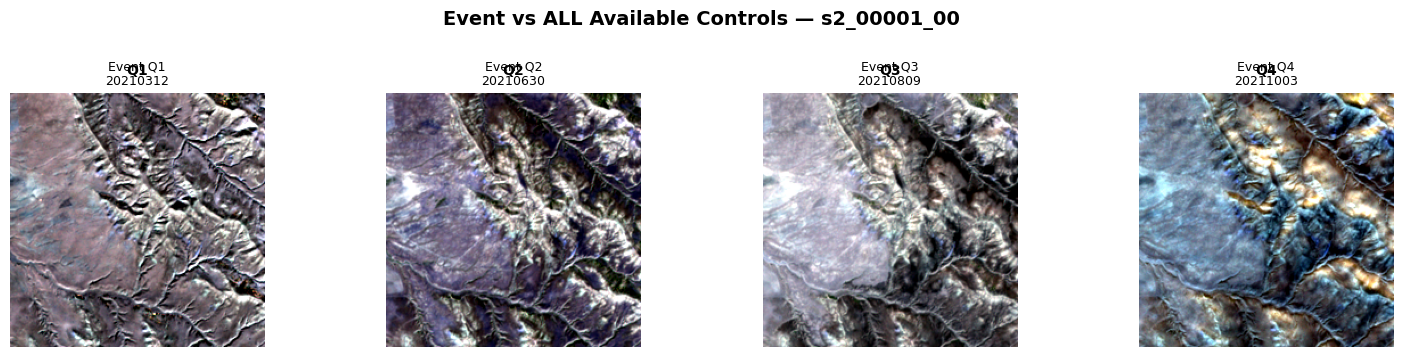

In [7]:
# Example inputs
root_dir = "../data/fire_data_v5/"

# Pick specific event chips you want to anchor on (any quarters are fine):
# selected_event_chip_ids = [
#     "s2_00786_05_e_Q1_20220123",
#     "s2_00786_05_e_Q2_20220528",
#     "s2_00786_05_e_Q3_20220905",
#     "s2_00786_05_e_Q4_20221005",
#     # add more event chip_ids (with or without .tif)
# ]

selected_event_chip_ids = [
    "s2_00001_00_e_Q1_20210312",
    "s2_00001_00_e_Q2_20210630",
    "s2_00001_00_e_Q3_20210809",
    "s2_00001_00_e_Q4_20211003",
    # add more event chip_ids (with or without .tif)
]

# Optional: include metadata so pre/post dates appear under each tile
# metadata_df has columns: chip_id, pre_date, post_date
visualize_controls_for_selected_events(
    root_dir=root_dir,
    selected_event_chip_ids=selected_event_chip_ids,
    quarters=("Q1","Q2","Q3","Q4"),
    band_indices=(0,1,2),      # adjust if your visible bands differ
    metadata_df=metadata_df     # or None
)


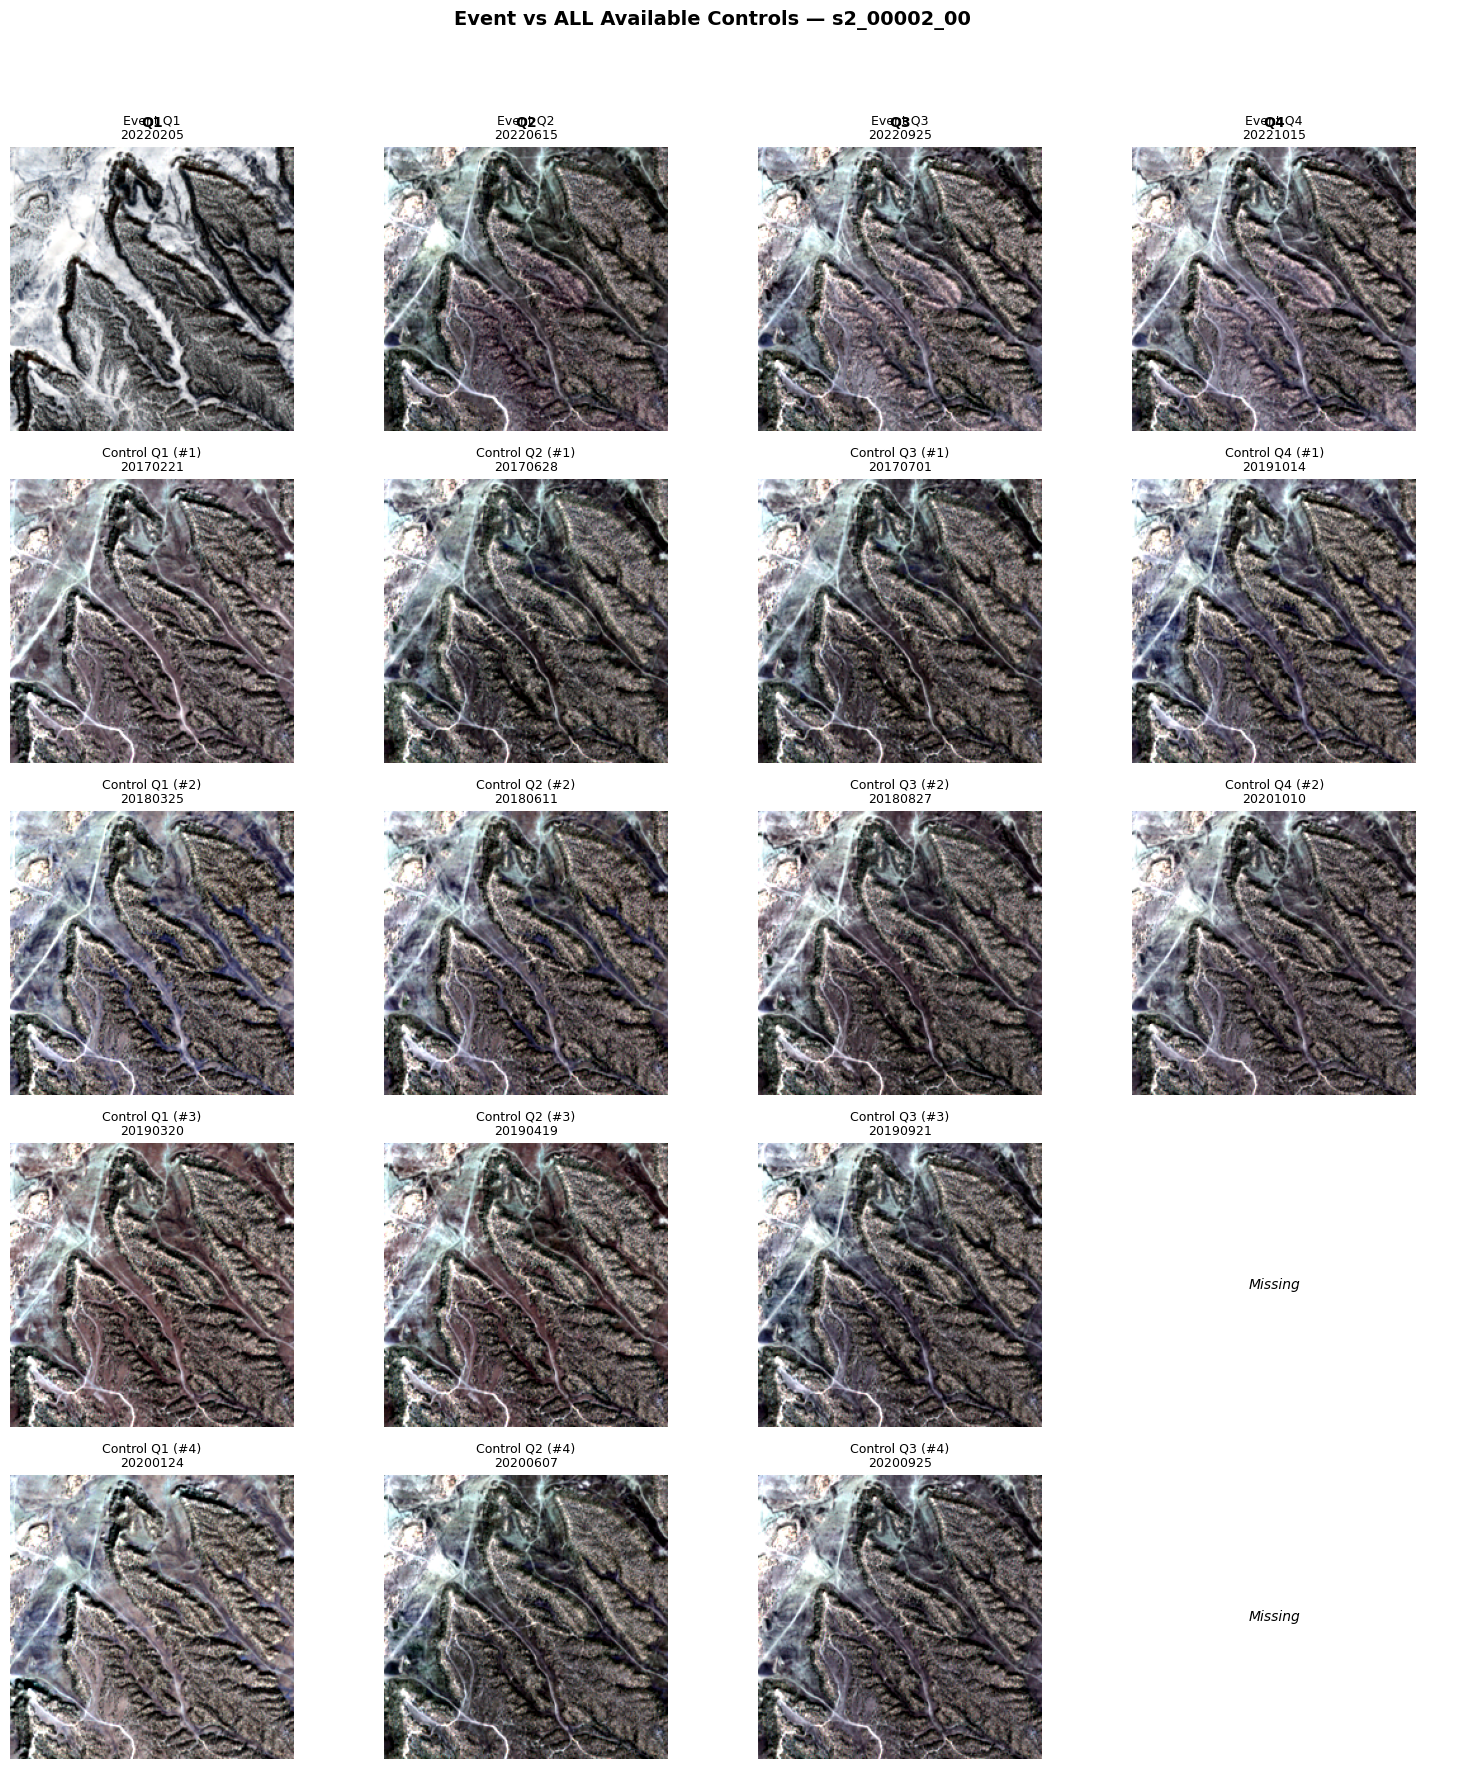

In [8]:
selected_event_chip_ids = [
    "s2_00002_00_e_Q1_20220205",
    "s2_00002_00_e_Q2_20220615",
    "s2_00002_00_e_Q3_20220925",
    "s2_00002_00_e_Q4_20221015",
    # add more event chip_ids (with or without .tif)
]

# Optional: include metadata so pre/post dates appear under each tile
# metadata_df has columns: chip_id, pre_date, post_date
visualize_controls_for_selected_events(
    root_dir=root_dir,
    selected_event_chip_ids=selected_event_chip_ids,
    quarters=("Q1","Q2","Q3","Q4"),
    band_indices=(0,1,2),      # adjust if your visible bands differ
    metadata_df=metadata_df     # or None
)